In [1]:
import rpy2.robjects as ro
import rpy2.robjects.packages as rpackages
import anndata as ad
import scanpy as sc
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from keras.callbacks import EarlyStopping
import seaborn as sb
from scipy.spatial.distance import pdist
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
import time
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
import math
import random
import rpy2.robjects as ro
from rpy2 import robjects
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import pydot

# adata = sc.read('/tmp/work/RCproject_code/sce_export.h5ad')
epoch_count = 0

# Enable automatic conversion between R objects and pandas DataFrames
pandas2ri.activate()

#exclude partial
# adata = adata[~adata.obs['Response'].isin(['partial']), :]

2025-01-20 15:03:13.685605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
test_set_size = 0.1
dropout_rate = 0.3 #0.1
balance = True
l2_reg = 0.2
batch_size = 16  #determines how many samples are processed per batch, each epoch will process multiple batches
# learning_rate = 0.00001
learning_rate = 0.01
num_epochs = 100000
report_frequency = 1
accuracy_threshold = 0.9  #currently not used
auc_threshold = 0.90
clipnorm = 2.0
simplifly_categories = True
holdout_size = 0.5

use_boruta_list = False
use_gene_list = False
use_diff_genes = False
use_imported_genes = True
current_gene_list = 'de_intersect_plus_bulk_genes'#'sig9_0.05'
# current_gene_list = 'Boruta_6'

PCA_reduce = False
n_comp_PCA = 16

multiplier = 3 #0.91 performance with 3

#dynamic learning rate parameters

lr_dict = {
    0.6:  0.005,
    0.7:  0.001,
    0.8:  0.0005,
    0.85: 0.0001,
    0.88: 0.00005,
    0.89: 0.00001,
    0.9:  0.000005,
    0.91: 0.000001,
    0.92: 0.0000005
}

auc_thresholds = [0.6, 0.7, 0.8, 0.85, 0.88,0.89,0.90,0.91,0.92]  # AUC values at which the learning rate should be adjusted

In [3]:
# Load the RDS file
rds_path = '/tmp/work/RCproject/gene_lists.rds'
rds_data = r.readRDS(rds_path)

# Extract the names of the lists and their contents
gene_lists = {}
for name, item in zip(rds_data.names, rds_data):
    # Each 'item' is a list associated with the 'name'
    inner_list = list(item)  # Convert the inner R list to a Python list
    gene_lists[name] = inner_list

# Now `python_data` is a dictionary with names as keys and lists as values
print(gene_lists.keys())

dict_keys(['meta', 'DE4', 'DEall', 'meta_intersect_unionDE', 'de_intersect', 'de_intersect_plus_bulk_genes', '5k', 'CV', 'CV300', 'CV300_4MA', 'Boruta_4MA', 'Boruta_6', 'CVBig', 'final300', 'final350', 'final', 'sig_4_6_0.05', 'sig_4_6_0.1', 'sig9_0.05', 'sig9_0.01', 'sig9', 'GEOMX_4_6_0.05_'])


In [4]:
# select a gene_list

current_genes = gene_lists[current_gene_list]
print(len(current_genes))

366


In [5]:
#import the data

# Function to read RDS file and extract counts and metadata
def read_rds_to_matrix_and_metadata(file_path):
    # Load the RDS file in R
    ro.r(f"sce <- readRDS('{file_path}')")

    # Extract count data (assumed to be stored in assays)
    counts = ro.r('assay(sce, "scalelogcounts")')
    # Extract row (gene) and column (cell) names
    gene_names = ro.r('rownames(sce)')
    cell_names = ro.r('colnames(sce)')
    
    # Convert to a NumPy array
    counts_np = ro.conversion.rpy2py(counts)

    # Convert the counts matrix to a pandas DataFrame
    counts_df = pd.DataFrame(counts_np, index=gene_names, columns=cell_names)

    # Extract metadata from colData and convert to a pandas DataFrame directly
    metadata = ro.r('as.data.frame(colData(sce))')  # Get the colData as an R data frame
    metadata_df = pd.DataFrame(metadata)  # Convert R data frame to pandas DataFrame directly

    return counts_df, metadata_df

# Usage example
file_path = '/tmp/work/RCproject/GEO_singlecellexperiment.rds'
counts_df, metadata_df = read_rds_to_matrix_and_metadata(file_path)

# Display the results
print("Counts DataFrame:")
print(counts_df.head())  # Show the first few rows of the counts DataFrame
print("\nMetadata DataFrame:")
print(metadata_df.head())  # Show the first few rows of the metadata DataFrame

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowC

Counts DataFrame:
        GSM3899156_GSE133057  GSM3899157_GSE133057  GSM3899158_GSE133057  \
A1CF                0.057669             -0.027535              0.447468   
A2M                 0.392288             -0.233300             -0.691535   
A2ML1              -0.448972             -0.560902             -0.670516   
A4GALT             -0.218099              0.224682             -0.247762   
AAAS               -1.148204             -0.252932              0.053839   

        GSM3899159_GSE133057  GSM3899160_GSE133057  GSM3899161_GSE133057  \
A1CF                0.045675              0.014587              1.406735   
A2M                 0.293834             -1.091569             -0.816868   
A2ML1               0.532968              0.516362              1.266745   
A4GALT             -1.663294             -0.673025              0.513021   
AAAS                0.442668              0.006890              0.582186   

        GSM3899162_GSE133057  GSM3899163_GSE133057  GSM3899164_GSE13

In [6]:
# X_train_diff, X_test, y_train_diff, y_test = train_test_split(counts_df.T, metadata_df, test_size=test_set_size, random_state=1)

In [7]:
# filtered_counts_df = X_train_diff.T
# filtered_metadata_df = y_train_diff

# if use_diff_genes:

#     from scipy.stats import ttest_ind
    
#     # Example: Two conditions
#     condition1 = filtered_counts_df.loc[:, filtered_metadata_df['Response'] == 'yes']
#     condition2 = filtered_counts_df.loc[:, filtered_metadata_df['Response'] == 'no']
    
#     # Apply t-test for each gene
#     p_values = []
#     for gene in filtered_counts_df.index:
#         t_stat, p_val = ttest_ind(condition1.loc[gene], condition2.loc[gene], equal_var=False)
#         p_values.append(p_val)
    
#     # Adjust for multiple testing using FDR
#     from statsmodels.stats.multitest import multipletests
#     adjusted_pvals = multipletests(p_values, method='fdr_bh')[1]
    
#     # Example: Genes and their p-values
#     genes = filtered_counts_df.index  # List of gene names
#     p_values_df = pd.DataFrame({'Gene': genes, 'P_value': adjusted_pvals})
    
#     # Filter genes with p-value < 0.1
#     filtered_genes = p_values_df[p_values_df['P_value'] < 0.015]
    
#     # Get a list of the gene names
#     filtered_gene_list = filtered_genes['Gene'].tolist()
    
#     # Display the filtered genes
#     print(f"Number of genes with p-value < 0.015: {len(filtered_gene_list)}")
#     print(filtered_gene_list)

In [8]:
if use_boruta_list:
    counts_df = counts_df.loc[selected_features]

if use_gene_list:
    counts_df = counts_df.loc[current_genes]

if use_diff_genes:
    counts_df = counts_df.loc[filtered_gene_list]
    
if use_imported_genes:
    # imported_genes = read
    # saveRDS(de_intersect_plus_bulk_genes,'ann_gene_set.rds')
    rds_path = '/tmp/work/RCproject_code/sean_ann_python/ann_gene_set.rds'
    current_genes = r.readRDS(rds_path)
    print(len(current_genes))
    counts_df = counts_df.loc[current_genes]

counts_df.shape[0]

366


366

In [9]:
filtered_metadata_df = metadata_df[~metadata_df['Response'].isin(['partial'])].copy()

row_names = filtered_metadata_df.index.tolist()  # Convert index to a list

filtered_counts_df = counts_df[row_names].copy()

In [10]:
# adata = metadata_df[~adata.obs['Response'].isin(['partial']), :]

In [11]:
# generate numerical values for each batch category
# set up categories variable

# categories_technology = adata.obs['batch']
categories_technology = filtered_metadata_df['batch']

#collapse the categories to microARRAY vs sequencing

if simplifly_categories:
    category_map = {'GSE133057': 'micro', 'GSE145037': 'micro', 'GSE150082': 'micro','GSE190826':'seq','GSE209746':'seq',
                    'GSE45404_GPL1': 'micro', 'GSE45404_GPL2': 'micro', 'GSE93375': 'micro','GSE94104': 'micro'}
    categories_technology = np.vectorize(category_map.get)(categories_technology)
    
# Create a LabelEncoder instance
label_encoder = LabelEncoder()
# Fit and transform the categories to integers
numerical_categories_technology = label_encoder.fit_transform(categories_technology)
print(numerical_categories_technology.shape)

#do the same for the response variable

# categories_outcome = adata.obs['Response']
categories_outcome = filtered_metadata_df['Response']

numerical_categories_outcome = label_encoder.fit_transform(categories_outcome)
print(numerical_categories_technology.shape)

(410,)
(410,)


In [12]:
frequency_counts = pd.Series(numerical_categories_technology).value_counts()
print('Technology frequencies')
print(frequency_counts)

print('')

print('Outcome frequencies')
frequency_counts = pd.Series(numerical_categories_outcome).value_counts()
print(frequency_counts)

unique_combinations_array = (numerical_categories_outcome + (numerical_categories_technology+1)*2)-2

np.unique(unique_combinations_array)

Technology frequencies
0    209
1    201
Name: count, dtype: int64

Outcome frequencies
0    267
1    143
Name: count, dtype: int64


array([0, 1, 2, 3])

In [13]:
# Assuming filtered_metadata_df is your filtered DataFrame
filtered_metadata_df.loc[:, 'numerical_categories_technology'] = numerical_categories_technology
filtered_metadata_df.loc[:, 'numerical_categories_outcome'] = numerical_categories_outcome
filtered_metadata_df.loc[:, 'combination_tech_outcome'] = unique_combinations_array

In [14]:
#normalizaiton
# gene_expression_data = adata.layers['scalelogcounts']

gene_expression_data = filtered_counts_df.T

#Min-max normalization

scaler = MinMaxScaler()
gene_expression_data = scaler.fit_transform(gene_expression_data)

number_genes = gene_expression_data.shape[1]
input_dim = number_genes

if PCA_reduce:
# Initialize PCA and fit it to X_train
    n_components = n_comp_PCA  # You can adjust this based on your data
    pca = PCA(n_components=n_components)
    gene_expression_data = pca.fit_transform(gene_expression_data)

In [15]:
# setup the test and train datasets
X_train, X_test, y_train, y_test = train_test_split(gene_expression_data, filtered_metadata_df, test_size=test_set_size, random_state=1)

y_train_outcome = y_train['numerical_categories_outcome']
y_test_outcome = y_test['numerical_categories_outcome']

y_train_tech = y_train['numerical_categories_technology']
y_test_tech = y_test['numerical_categories_technology']

y_train_comb = y_train['combination_tech_outcome']
y_test_comb = y_test['combination_tech_outcome']

In [16]:
train_samples = y_train.index.tolist()

# Export the row names to a file in a format readable by R
with open('train_samples.txt', 'w') as f:
    for name in train_samples:
        f.write(f"{name}\n")

In [17]:
# len(selected_features)

In [18]:
# #  boruta filtering

# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestClassifier
# from boruta import BorutaPy

# boruta_df = filtered_counts_df[train_samples]
# boruta_df = boruta_df.T
# boruta_df['outcome'] = y_train_outcome.tolist()  # Ensure it’s a Python list

# # Define features (X) and target (y)
# X = boruta_df.drop(columns=["outcome"])  # Features (gene expressions)
# y = boruta_df["outcome"]  # Target (e.g., disease vs. control)
# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)

# boruta_selector = BorutaPy(
#     estimator=rf,
#     n_estimators='auto',
#     alpha=0.05,   # Significance level
#     perc=50,      # Shadow importance threshold
#     max_iter=100, # Iterations
#     random_state=42
# )

# # Fit and transform data
# boruta_selector.fit(X.values, y.values)
# selected_features = X.columns[boruta_selector.support_].tolist()

# # Fit Boruta
# boruta_selector.fit(X.values, y.values)

# # Get selected features
# selected_features = X.columns[boruta_selector.support_].tolist()
# print("Selected Features:", selected_features)
# print(len(selected_features))

In [19]:
# # Define the input shape
# # input_shape = (gene_expression_data.shape[1],)[0]  # Number of genes

input_shape = (X_train.shape[1],)[0]  # Number of genes

def build_outcome_classifier():
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))  # Input shape matches your data
    
    model.add(layers.Dense((512*multiplier),kernel_regularizer=tf.keras.regularizers.l2(l2_reg),kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))  # Leaky ReLU helps with vanishing gradients
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense((256*multiplier),kernel_regularizer=tf.keras.regularizers.l2(l2_reg),kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense((128*multiplier),kernel_regularizer=tf.keras.regularizers.l2(l2_reg),kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense((64*multiplier),kernel_regularizer=tf.keras.regularizers.l2(l2_reg),kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense((32),kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.1))
    
    # Output layer for binary classification with sigmoid activation
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

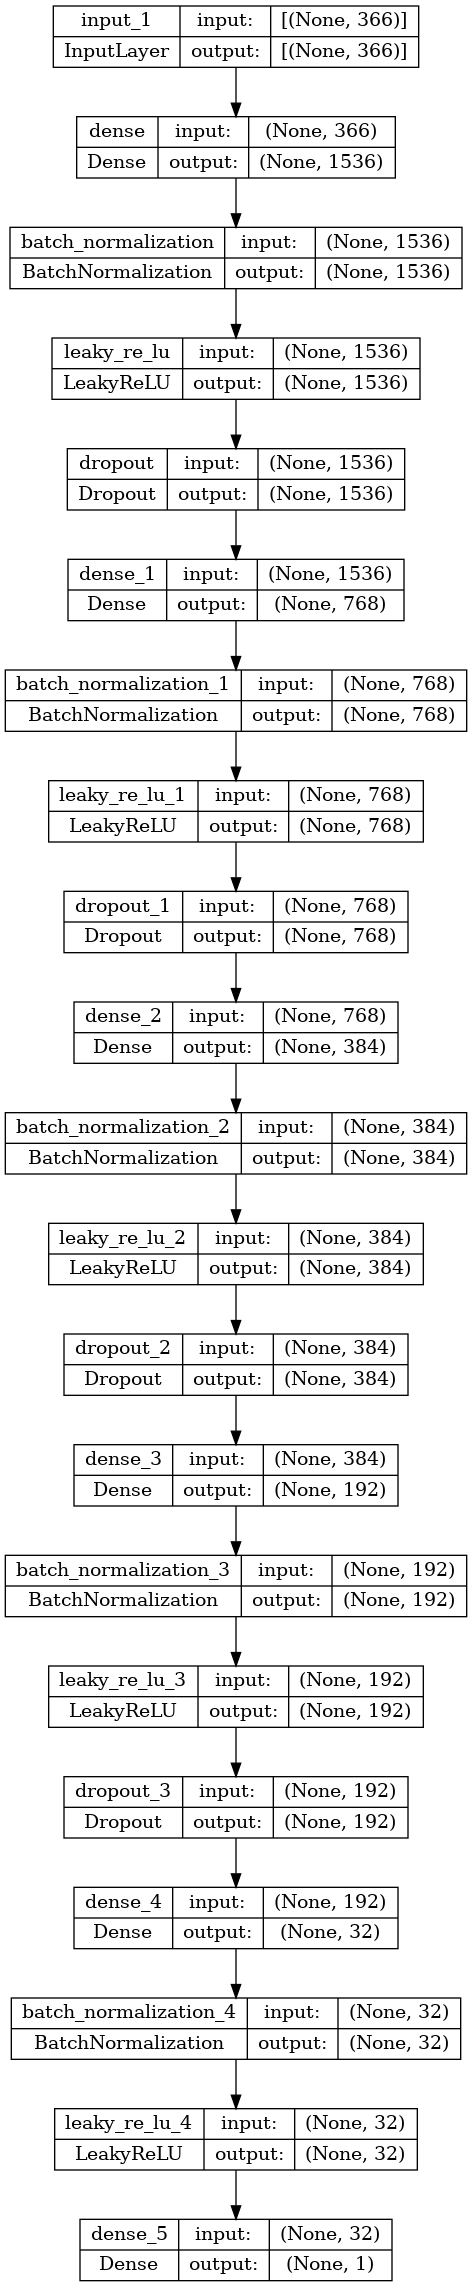

In [20]:
# Define the model
outcome_classifier = build_outcome_classifier()

# Assuming `model` is your TensorFlow/Keras model
plot_model(outcome_classifier, to_file="model.png", show_shapes=True, show_layer_names=True)

In [21]:
# Define the callback-like function to adjust learning rate based on AUC
def adjust_learning_rate_by_auc(epoch, model, X_test, y_test_outcome, lr_dict, auc_thresholds,test_auc):
    # Get model's current learning rate
    current_lr = tf.keras.backend.get_value(model.optimizer.lr)

    # Adjust learning rate based on AUC thresholds
    new_lr = current_lr
    for threshold in auc_thresholds:
        if test_auc >= threshold:
            new_lr = lr_dict[threshold]
    
    # Set new learning rate
    if new_lr != current_lr:
        tf.keras.backend.set_value(model.optimizer.lr, new_lr)
        #print(f"Epoch {epoch + 1}: Adjusting learning rate to {new_lr:.6f}")
    
    return test_auc


In [22]:
# # set up the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm = clipnorm)

# determine the sample and batch size
num_samples = math.floor(X_train.shape[0]* (1-holdout_size))  # number of samples used in each training epoch

# batch_size = adata.shape[0]

# Calculate the number of steps per epoch
num_steps_per_epoch = num_samples // batch_size

# Compile the outcome discriminator
outcome_classifier.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
test_accuracy_list = []
train_accuracy_list = []
test_auc_list = []

num_outcomes = len(np.unique(y_test_outcome))
num_conditions = len(np.unique(unique_combinations_array))

# Define the training step for only the outcome classifier
def train_step(data, outcome_labels):
    with tf.GradientTape() as tape:
        # Forward pass through the outcome classifier
        outcome_predictions = outcome_classifier(data)

        # Compute the biological discriminator loss
        outcome_loss = tf.keras.losses.binary_crossentropy(outcome_labels, outcome_predictions)
        outcome_loss = tf.reduce_mean(outcome_loss)  # Average over the batch

    # Compute gradients for the outcome classifier
    classifier_grads = tape.gradient(outcome_loss, outcome_classifier.trainable_variables)
    
    # Calculate accuracy for the outcome classifier
    predicted_outcome_labels = tf.cast(outcome_predictions > 0.5, tf.float32)  # Threshold at 0.5
    outcome_labels_float = tf.cast(outcome_labels, tf.float32)

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_outcome_labels, outcome_labels_float), tf.float32))

    return outcome_loss, accuracy, classifier_grads

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0  # To accumulate losses
    total_accuracy = 0.0  # To accumulate accuracy
    accumulated_grads = [tf.zeros_like(var) for var in outcome_classifier.trainable_variables]  # Initialize gradient accumulator

    # Split train data randomly, holding out a portion for generalization
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, test_size=holdout_size, random_state=None)
    y_train_comb_temp = y_train_temp['combination_tech_outcome']
    y_train_temp = y_train_temp['numerical_categories_outcome']
    
    # Mini-batch training loop
    for step in range(num_steps_per_epoch):
        # Balance batches if necessary
        batch_indices = []
        if balance:
            for condition in range(num_conditions):
                condition_indices = np.where(y_train_comb_temp == condition)[0]
                condition_batch_indices = np.random.choice(condition_indices, size=batch_size // num_conditions, replace=True)
                batch_indices.append(condition_batch_indices)
        else:
            all_indices = np.arange(len(X_train_temp))
            random_indices = np.random.choice(all_indices, size=batch_size, replace=True)
            batch_indices.append(random_indices)
        X_batch = X_train_temp[np.concatenate(batch_indices)]
        #y_batch = y_train_temp[np.concatenate(batch_indices)]
        y_batch = y_train_temp.iloc[np.concatenate(batch_indices)]
        y_batch = tf.expand_dims(y_batch, axis=-1)  # Adjust labels shape for binary_crossentropy
                
        # Perform the training step and collect gradients
        outcome_loss, accuracy, classifier_grads = train_step(X_batch, y_batch)
        
        # Accumulate gradients and losses
        total_loss += outcome_loss.numpy()
        total_accuracy += accuracy.numpy()
        accumulated_grads = [acc_grad + grad for acc_grad, grad in zip(accumulated_grads, classifier_grads)]

    # Average the accumulated gradients
    averaged_grads = [grad / num_steps_per_epoch for grad in accumulated_grads]

    # Apply averaged gradients to update model weights
    optimizer.apply_gradients(zip(averaged_grads, outcome_classifier.trainable_variables))

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / num_steps_per_epoch
    avg_accuracy = total_accuracy / num_steps_per_epoch

    if epoch % report_frequency == 0:

        #adjust the learning rate depending on test set performance
        # adjust_learning_rate_by_auc(epoch, outcome_classifier, X_test_temp, y_test_temp['numerical_categories_outcome'], lr_dict, auc_thresholds)
        
        # Evaluate on test data
        outcome_predictions = outcome_classifier(X_test)
        outcome_labels = tf.expand_dims(y_test_outcome, axis=-1)  # Reshape to match logits shape
        outcome_labels_float = tf.cast(outcome_labels, tf.float32)
    
        # Calculate AUC
        outcome_predictions_np = outcome_predictions.numpy().flatten()  # Convert predictions to numpy for roc_auc_score
        outcome_labels_np = outcome_labels_float.numpy().flatten()  # Convert labels to numpy for roc_auc_score
        test_auc = roc_auc_score(outcome_labels_np, outcome_predictions_np)

        # Calculate accuracy
        predicted_outcome_labels = tf.cast(outcome_predictions > 0.5, tf.float32)  # Threshold at 0.5
        outcome_labels_float = tf.cast(outcome_labels, tf.float32)
        test_accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted_outcome_labels, outcome_labels_float), tf.float32))
    
        # Store and print metrics
        train_accuracy_list.append(avg_accuracy)
        test_auc_list.append(test_auc)
        test_accuracy_list.append(test_accuracy)
        
        if epoch % (report_frequency*100) == 0:
            print(f'Epoch {epoch}, Average Outcome Loss: {avg_loss}, Average Accuracy: {avg_accuracy}, Test AUC: {test_auc:.4f}, Test Accuracy: {test_accuracy:.4f}')

        adjust_learning_rate_by_auc(epoch, outcome_classifier, X_test_temp, y_test_temp['numerical_categories_outcome'], lr_dict, auc_thresholds, test_auc)
    
        # Early stopping condition for AUC (if needed)
        if test_auc > auc_threshold:  # Define auc_threshold as desired
            print('Early stopping triggered based on AUC')
            break

Epoch 0, Average Outcome Loss: 0.6987846222790804, Average Accuracy: 0.48863636363636365, Test AUC: 0.5000, Test Accuracy: 0.3659
Epoch 100, Average Outcome Loss: 0.621192065152255, Average Accuracy: 0.6761363636363636, Test AUC: 0.7179, Test Accuracy: 0.6829
Epoch 200, Average Outcome Loss: 0.5078744481910359, Average Accuracy: 0.7272727272727273, Test AUC: 0.8051, Test Accuracy: 0.7073
Epoch 300, Average Outcome Loss: 0.41663766449148004, Average Accuracy: 0.7954545454545454, Test AUC: 0.8462, Test Accuracy: 0.7805
Epoch 400, Average Outcome Loss: 0.36267228560014203, Average Accuracy: 0.8181818181818182, Test AUC: 0.8359, Test Accuracy: 0.7805
Epoch 500, Average Outcome Loss: 0.6093041463331743, Average Accuracy: 0.7215909090909091, Test AUC: 0.8590, Test Accuracy: 0.7805
Epoch 600, Average Outcome Loss: 0.4248193475333127, Average Accuracy: 0.8295454545454546, Test AUC: 0.8513, Test Accuracy: 0.7805
Epoch 700, Average Outcome Loss: 0.4486587873914025, Average Accuracy: 0.7443181818

In [24]:
print(max(test_auc_list))
print(max(test_accuracy_list))
print(max(train_accuracy_list))

0.8794871794871795
tf.Tensor(0.85365856, shape=(), dtype=float32)
1.0


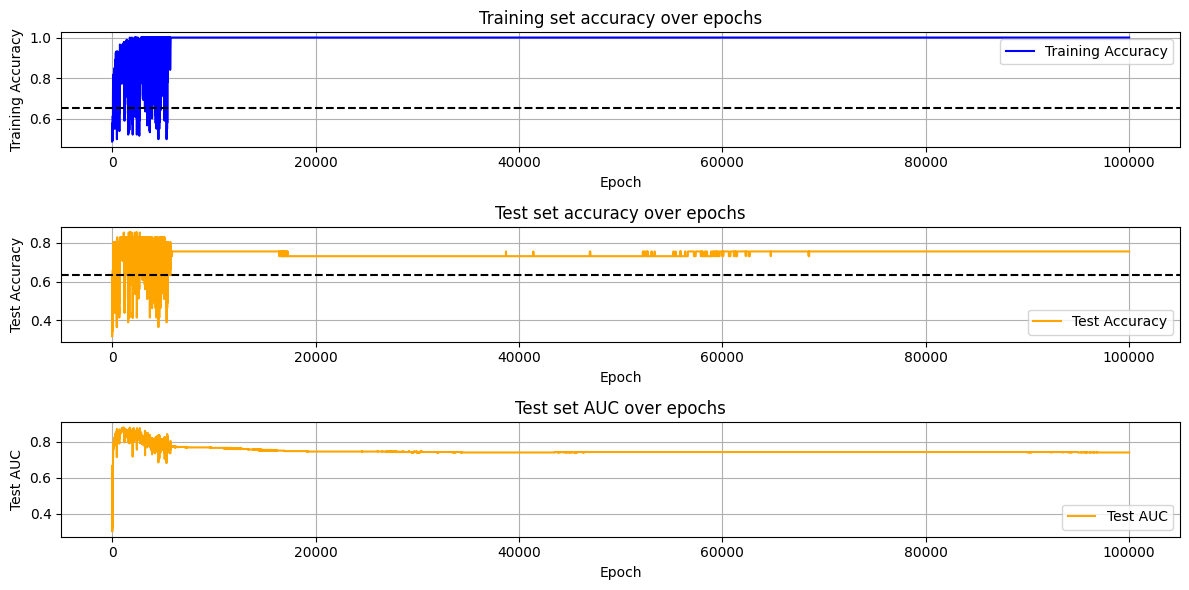

In [25]:
# After training, plot the metrics

frequency_counts = pd.Series(y_test_outcome).value_counts()
test_chance_level = frequency_counts[0]/len(y_test_outcome)

frequency_counts = pd.Series(y_train_outcome).value_counts()
train_chance_level = frequency_counts[0]/len(y_train_outcome)

fig, axs = plt.subplots(3, 1, figsize=(12, 6))

x_values = np.arange(1, len(train_accuracy_list) + 1) * report_frequency

# Plot train accuracy
axs[0].plot(x_values, train_accuracy_list, label='Training Accuracy', color='blue')
axs[0].axhline(train_chance_level, color='black',linestyle ='--')
axs[0].set_title('Training set accuracy over epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Accuracy')
axs[0].grid()
axs[0].legend()

# Plot test accuracay
axs[1].plot(x_values, test_accuracy_list, label='Test Accuracy', color='orange')
axs[1].axhline(test_chance_level, color='black',linestyle ='--')
axs[1].set_title('Test set accuracy over epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Test Accuracy')
axs[1].grid()
axs[1].legend()

# Plot test accuracay
axs[2].plot(x_values, test_auc_list, label='Test AUC', color='orange')
# axs[2].axhline(0.5, color='black',linestyle ='--')
axs[2].set_title('Test set AUC over epochs')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Test AUC')
axs[2].grid()
axs[2].legend()

plt.tight_layout()
plt.show()

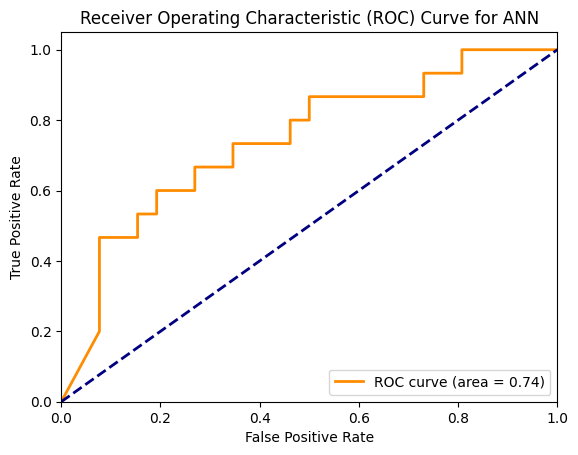

In [26]:
# After loop: Calculate ROC and AUC using continuous probabilities
fpr, tpr, thresholds = roc_curve(y_test_outcome, outcome_predictions)  # Use probabilities, not thresholded labels
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ANN')
plt.legend(loc="lower right")
plt.show()

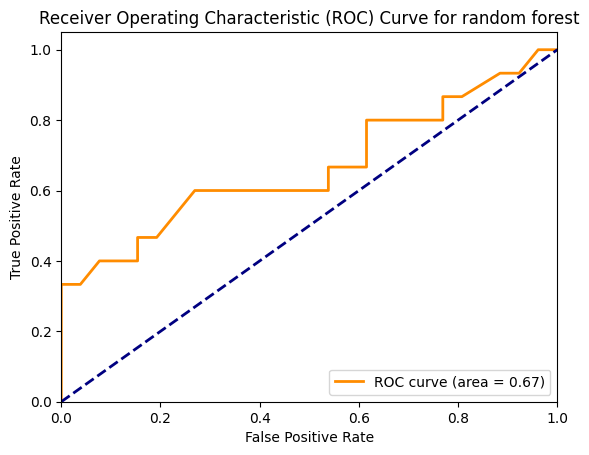

In [27]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_outcome)

y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class (class 1)

fpr, tpr, thresholds = roc_curve(y_test_outcome, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for random forest')
plt.legend(loc="lower right")
plt.show()